In [1]:
%load_ext tensorboard
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from datetime import datetime

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

2022-12-22 12:26:40.634745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 12:26:41.589264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-22 12:26:41.589353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-22 12:26:41.589364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

time: 269 µs (started: 2022-12-22 12:26:43 +01:00)


/home/abdel/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


2022-12-22 12:26:43.204310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-22 12:26:43.204377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-12-22 12:26:43.205026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


time: 213 ms (started: 2022-12-22 12:26:43 +01:00)


In [3]:
def get_adversial_exemple(model, dataset, eps):
  adversarial_examples = []
  for images, labels in dataset:
    with tf.GradientTape() as tape:
      tape.watch(images)
      predictions = model(images)
      loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_example = images + eps * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)
    adversarial_examples.append(adversarial_example)
  adversarial_examples = np.concatenate(adversarial_examples,axis=0)
  return adversarial_examples


time: 1.64 ms (started: 2022-12-22 12:26:43 +01:00)


In [4]:
# Shallow softmax model

shallow_softmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_softmax.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_softmax.fit(ds_train, epochs=5)
shallow_softmax.evaluate(ds_test)


Epoch 1/5
469/469 [==============================] - 5s 5ms/step - loss: 0.6922 - accuracy: 0.8278
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3640 - accuracy: 0.9015
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3207 - accuracy: 0.9120
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3006 - accuracy: 0.9165
Epoch 5/5
79/79 [==============================] - 1s 7ms/step - loss: 0.2786 - accuracy: 0.9222


[0.27864018082618713, 0.9222000241279602]

time: 14.8 s (started: 2022-12-22 12:26:43 +01:00)


In [5]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100),
  tfa.layers.Maxout(50),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=5)
shallow_maxout.evaluate(ds_test) 


Epoch 1/5
469/469 [==============================] - 4s 6ms/step - loss: 0.3964 - accuracy: 0.8907
Epoch 2/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1477 - accuracy: 0.9582
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1044 - accuracy: 0.9701
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0809 - accuracy: 0.9763
Epoch 5/5
79/79 [==============================] - 0s 3ms/step - loss: 0.1003 - accuracy: 0.9693


[0.10033737868070602, 0.9692999720573425]

time: 16.6 s (started: 2022-12-22 12:26:58 +01:00)


In [6]:
# convert tf.data.Dataset to numpy array
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)
x_train = np.concatenate([x for x, y in ds_train], axis=0)
y_train = np.concatenate([y for x, y in ds_train], axis=0)

time: 820 ms (started: 2022-12-22 12:27:14 +01:00)


In [7]:
# avaluate shallow_softmax model on adversarial examples
x_test_adv = get_adversial_exemple(shallow_softmax, ds_test, eps=0.25)
loss, accuracy =  shallow_softmax.evaluate(x_test_adv, y_test)
confidence = np.mean(np.max(shallow_softmax.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )


313/313 [==============================] - 0s 1ms/step
Accuracy on adversarial examples: 0.0 with a mean confidence of 0.8783888816833496
time: 1.89 s (started: 2022-12-22 12:27:15 +01:00)


In [8]:
# evaluate shallow_maxout model on adversarial examples
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test)
confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )


313/313 [==============================] - 1s 2ms/step
Accuracy on adversarial examples: 0.002300000051036477 with a mean confidence of 0.9273859262466431
time: 2.79 s (started: 2022-12-22 12:27:17 +01:00)


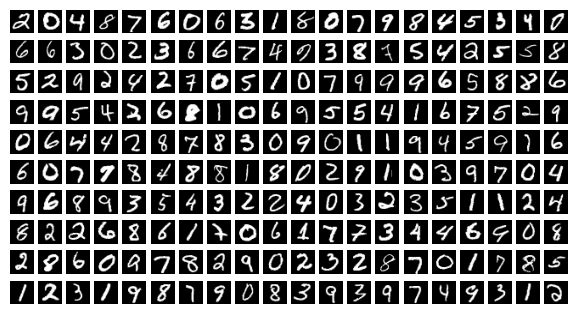

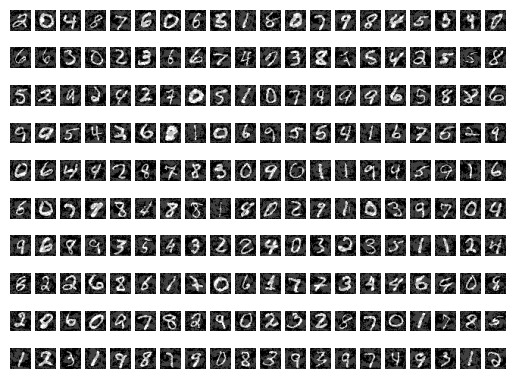

time: 10.5 s (started: 2022-12-22 12:27:20 +01:00)


In [9]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(1)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.figure(2)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test_adv[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')

plt.show()


In [10]:

class SequentialAdversarialLoss(tf.keras.Sequential):
    def __init__(self, *args, **kwargs):
        super(SequentialAdversarialLoss, self).__init__(*args, **kwargs)
        self.alpha = 0.5
        self.a = []
        self.eps = 0.25
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        """for i in x:
            print(x)
        print(tf.identity(x))
        dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(tf.identity(x),0),tf.expand_dims(tf.identity(y),0)))
        print(dataset)
        print("-------------------")
        adv_x = get_adversial_exemple(self,dataset,0.25)
        print("++++++++++++++++++++++")"""

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            #tape.watch(adv_x)
            y_pred = self(x, training=True)  # Forward pass
            
            #adv_y_pred = self(adv_x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred)
            
        gradient = tape.gradient(loss, x)
        signed_grad = tf.sign(gradient)
        x_adv = x + 0.25 * signed_grad
        x_adv = tf.clip_by_value(x_adv, 0, 1)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_adv)
            y_pred_adv = self(x_adv, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss *= self.alpha 
            loss += (1 - self.alpha) * self.compiled_loss(y, y_pred_adv)
            
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        del tape
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value

        return {m.name: m.result() for m in self.metrics}
    

time: 2.6 ms (started: 2022-12-22 12:27:30 +01:00)


In [11]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = SequentialAdversarialLoss([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(960),
  tfa.layers.Maxout(240),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(960),
  tfa.layers.Maxout(240),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=20)

print("------------------Train dataset-------------")
shallow_maxout.evaluate(ds_train) 
x_train_adv = get_adversial_exemple(shallow_maxout, ds_train, eps=0.25)
_, accuracy =  shallow_maxout.evaluate(x_train_adv, y_train, verbose = 0)
confidence = np.mean(np.max(shallow_maxout.predict(x_train_adv, verbose = 0), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} \n with a mean confidence of {confidence}", )
print("------------------Test dataset-------------")
shallow_maxout.evaluate(ds_test) 
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test, verbose = 0)
confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv, verbose = 0), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} \n with a mean confidence of {confidence}", )

Epoch 1/20
469/469 [==============================] - 13s 25ms/step - loss: 1.3107 - accuracy: 0.7348
Epoch 2/20
469/469 [==============================] - 12s 25ms/step - loss: 0.9965 - accuracy: 0.8505
Epoch 3/20
469/469 [==============================] - 11s 24ms/step - loss: 0.8971 - accuracy: 0.8782
Epoch 4/20
469/469 [==============================] - 12s 24ms/step - loss: 0.8334 - accuracy: 0.8918
Epoch 5/20
469/469 [==============================] - 11s 24ms/step - loss: 0.7841 - accuracy: 0.8989
Epoch 6/20
469/469 [==============================] - 12s 24ms/step - loss: 0.7472 - accuracy: 0.9083
Epoch 7/20
469/469 [==============================] - 11s 24ms/step - loss: 0.7223 - accuracy: 0.9100
Epoch 8/20
469/469 [==============================] - 11s 24ms/step - loss: 0.6947 - accuracy: 0.9156
Epoch 9/20
469/469 [==============================] - 11s 24ms/step - loss: 0.6675 - accuracy: 0.9200
Epoch 10/20
469/469 [==============================] - 11s 24ms/step - loss: 0.631

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(960),
  tfa.layers.Maxout(240),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(960),
  tfa.layers.Maxout(240),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=10,callbacks=[tensorboard_callback])

print("------------------Train dataset-------------")
shallow_maxout.evaluate(ds_train) 
x_train_adv = get_adversial_exemple(shallow_maxout, ds_train, eps=0.25)
_, accuracy =  shallow_maxout.evaluate(x_train_adv, y_train, verbose = 0)
print(f"Accuracy on adversarial examples: {accuracy}")
#confidence = np.mean(np.max(shallow_maxout.predict(x_train_adv, verbose = 0), axis=1))
#print(f"Accuracy on adversarial examples: {accuracy} \n with a mean confidence of {confidence}", )
print("------------------Test dataset-------------")
shallow_maxout.evaluate(ds_test) 
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test, verbose = 0)
print(f"Accuracy on adversarial examples: {accuracy}")

#confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv, verbose = 0), axis=1))
#print(f"Accuracy on adversarial examples: {accuracy} \n with a mean confidence of {confidence}", )

Epoch 1/10
469/469 [==============================] - 8s 15ms/step - loss: 0.4235 - accuracy: 0.8676
Epoch 2/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1921 - accuracy: 0.9430
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1568 - accuracy: 0.9545
Epoch 4/10
377/469 [=======================>......] - ETA: 1s - loss: 0.1389 - accuracy: 0.9588

In [ ]:
%tensorboard --logdir='logs/scalars'